# Chlorophyll comparison

# import packages and functions

In [1]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py

/Users/akbaskind/Documents/Python Scripts/phyto


In [2]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from importlib import reload
import warnings
warnings.filterwarnings('ignore')

# Pull data from [spreadsheet](https://docs.google.com/spreadsheets/d/1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10/edit#gid=0)

- opening all the datasets in the spreadsheet all at once
- `hydrocat620`
- `hydrocat720`
- `MV`
- `QP`

In [67]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

## Correct data types

In [68]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

# Get Time Series chlorophyll data from [this google sheet](https://docs.google.com/spreadsheets/d/1BdRyFMxiPv1A-qQj3ajAnZJOr-Sk43osT6BpJaYz248/edit#gid=0)

The spreadsheet has multiple worksheets

1. `All Data` has every weekly sample of chlorophyll and phaeophytin since 1999-1-25 until 2023-3-27.
2. `Monthly` provides average, standard deviation, max, and min of chlorophyll for each month averaged across all available years. For example, line 1 has the average of *all* Januaries. 
3. `Yearly` provides the annual average, standard deviation, max, and min of chlorophyll for each available year. Note end member years may have incomplete data. 
4. `Avg Chl Month-Year` provides the average chlorophyll indexed by month and year. Columns are months. Rows are years. For example, Column 0 Row 0 corresponds to January 1999, whereas Column 4 Row 5 corresponds to May 2004. 
5. `Std Chl Month-Year` provides the standard deviation of chlorophyll indexed by month and year. Columns are months. Rows are years. For example, Column 0 Row 0 corresponds to January 1999, whereas Column 4 Row 5 corresponds to May 2004. 

In [159]:
# Time Series Chlorophyll spreadsheet
spreadsheet_key = '1BdRyFMxiPv1A-qQj3ajAnZJOr-Sk43osT6BpJaYz248'
#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

# Worksheets
wks_all = 'All Data'
wks_month = 'Monthly'
wks_year = 'Yearly'
wks_avg = 'Avg Chl Month-Year'
wks_std = 'Std Chl Month-Year'
sheet = workbook.worksheet(wks_all)
values = sheet.get_all_values()
chl = pd.DataFrame(values[1:], columns = values[0])

## All chlorophyll
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_all)
values = sheet.get_all_values()
chl = pd.DataFrame(values[1:], columns = values[0])

## Monthly chlorophyll
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_month)
values = sheet.get_all_values()
chl_month = pd.DataFrame(values[1:], columns = values[0])

## Yearly chlorophyll
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_year)
values = sheet.get_all_values()
chl_year = pd.DataFrame(values[1:], columns = values[0])

## Monthly-Yearly Avg chl
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_avg)
values = sheet.get_all_values()
chl_avg = pd.DataFrame(values[1:], columns = values[0])

## Monthly-Yearly Std chl
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_std)
values = sheet.get_all_values()
chl_std = pd.DataFrame(values[1:], columns = values[0])

## Convert Data Types

In [160]:
for k in chl.keys():
    if k == 'Sample Date':
        chl[k] = pd.to_datetime(chl[k])
    elif k != 'Month':
        chl[k] = pd.to_numeric(chl[k])

for k in chl_month.keys():
    if k != 'Sample Date':
        chl_month[k] = pd.to_numeric(chl_month[k])
        
for k in chl_year.keys():
    if k != 'Sample Date':
        chl_year[k] = pd.to_numeric(chl_year[k])
        
for k in chl_avg.keys():
    if k != 'Years':
        chl_avg[k] = pd.to_numeric(chl_avg[k])
        
for k in chl_std.keys():
    if k != 'Years':
        chl_std[k] = pd.to_numeric(chl_std[k])

## `chl`: all chlorophyll data

In [85]:
chl.head()

,Month,Sample Date,Surface Chla All (µg/L),Surface Phaeo all (µg/L),Bottom Chla all (µg/L),Bottom Phaeo all (µg/L),surface chla <20 um (µg/L),Surface Phaeo <20 um (µg/L),Bottom Chla <20 um (µg/L),Bottom Phaeo <20 um (µg/L)
0,Jan,1999-01-25,3.72,0.80,3.26,1.15,NaN,NaN,NaN,NaN
1,Feb,1999-02-01,2.90,0.74,2.66,0.83,NaN,NaN,NaN,NaN
2,Feb,1999-02-08,2.20,0.94,3.24,1.98,NaN,NaN,NaN,NaN
3,Feb,1999-02-15,1.34,1.20,1.47,0.60,NaN,NaN,NaN,NaN
4,Feb,1999-02-22,12.56,5.33,9.04,4.97,NaN,NaN,NaN,NaN


## `chl_present`: all chlorophyll data from 2022 onward

In [95]:
chl_present = chl.where(chl['Sample Date'] >= datetime(2022,1,1)).dropna()
chl_present = chl_present.reset_index(drop=True)
chl_present.head()

,Month,Sample Date,Surface Chla All (µg/L),Surface Phaeo all (µg/L),Bottom Chla all (µg/L),Bottom Phaeo all (µg/L),surface chla <20 um (µg/L),Surface Phaeo <20 um (µg/L),Bottom Chla <20 um (µg/L),Bottom Phaeo <20 um (µg/L)
0,Jan,2022-01-04,7.61,3.23,7.46,3.71,3.17,2.07,2.49,2.64
1,Jan,2022-01-10,17.55,2.00,16.97,3.31,6.63,2.60,3.43,2.95
2,Jan,2022-01-16,20.39,2.43,20.86,4.82,1.88,2.38,4.65,2.77
3,Jan,2022-01-24,26.17,5.30,19.34,5.99,2.52,2.39,4.74,3.40
4,Jan,2022-01-31,20.13,3.88,20.08,10.75,2.17,3.04,2.48,5.25


## `chl_month`: monthly chlorophyll averages, stds, mins, and maxes

In [86]:
chl_month.head()

,Sample Date,Average of Surface Chla All (µg/L),StdDev of Surface Chla All (µg/L),Min of Surface Chla All (µg/L),Max of Surface Chla All (µg/L)
0,Jan,10.545438,12.346616,0.625136,63.140000
1,Feb,8.273352,7.378423,0.599676,31.547849
2,Mar,5.642602,4.723779,0.624578,21.776957
3,Apr,5.878116,6.050803,0.429761,29.800400
4,May,4.243530,3.355967,0.660982,22.339914


## `chl_year`: annual chlorophyll averages, stds, mins, and maxes

In [87]:
chl_year.head()

,Sample Date,Average of Surface Chla All (µg/L),StdDev of Surface Chla All (µg/L),Min of Surface Chla All (µg/L),Max of Surface Chla All (µg/L)
0,1999,7.691158,7.212672,1.236118,42.146353
1,2000,9.974835,5.829158,1.463498,31.992185
2,2001,9.107112,8.541141,0.861572,47.871730
3,2002,6.363680,5.117696,0.625136,31.547849
4,2003,6.261965,4.039834,0.573101,16.670224


## `chl_avg`: monthly-yearly chlorophyll averages
## `chl_std`: monthly-yearly chlorophyll standard deviations
These 2 datasets go together. Note that the data type of `Years` is actually string since the final row is "Grand Total." We can thank Excel PivotTables for that.

I also transposed these dataframes because it made them easier for me to manipulate.

In [161]:
CHL = chl_avg.T
CHL.columns=CHL.iloc[0]
CHL.drop(CHL.head(1).index,inplace=True)
chl_avg = CHL
chl_avg.head()

Years,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Grand Total
Jan,3.715639,9.741245,11.800104,1.279637,8.079113,25.361655,1.065609,2.762835,5.617041,23.978431,...,3.5275,2.597223,10.138,42.91,13.0417,1.993019,7.979836,18.37,15.110476,10.545438
Feb,4.749754,11.715438,6.236008,10.766564,8.351146,11.846864,2.903135,2.265066,12.99652,25.7621,...,4.7475,9.89,12.713414,7.9275,13.330117,3.582335,7.319558,8.982878,5.842601,8.273352
Mar,4.161985,11.520905,8.334978,4.008923,7.20515,7.088124,1.633193,3.105211,7.793792,15.37382,...,6.226,3.695,5.305,4.9225,6.020512,1.347701,1.093401,2.031413,0.93287,5.642602
Apr,7.50825,8.818673,10.218937,3.216135,11.107057,7.358774,15.352398,2.527319,12.561624,10.559796,...,3.2775,3.47,9.5575,5.154,2.49441,1.655487,1.124405,1.789871,NaN,5.878116
May,3.031139,9.737416,4.507321,7.617616,3.293675,4.211366,6.369533,3.157092,11.983772,4.601252,...,2.146,2.774,3.3,4.3975,3.871386,2.260738,1.82,2.018527,NaN,4.24353


In [162]:
CHL = chl_std.T
CHL.columns=CHL.iloc[0]
CHL.drop(CHL.head(1).index,inplace=True)
chl_std = CHL
chl_std.head()

Years,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Grand Total
Jan,NaN,2.582644,12.992486,0.733318,2.511005,6.773087,0.163722,1.753278,4.105799,19.092322,...,1.280583,0.744657,5.063948,21.729723,11.824265,0.787082,6.195321,6.79095,6.298118,12.346616
Feb,5.244874,1.939089,4.846895,13.916989,3.709698,1.647723,2.622692,0.791847,4.105081,9.094077,...,2.051168,7.029004,9.468909,9.107493,12.627367,1.853264,6.690305,5.31505,5.105236,7.378423
Mar,2.257117,2.89372,6.605519,0.679816,2.72511,5.131054,1.009083,1.438592,4.772873,5.70914,...,2.852977,3.011019,3.26544,1.690747,5.362339,0.72486,0.592991,1.179967,0.321923,4.723779
Apr,5.92516,8.454594,12.890839,1.304664,6.808037,6.207311,NaN,1.739595,9.748088,5.084619,...,2.253181,1.774091,2.747379,1.098217,1.002221,0.365544,0.221327,0.79223,NaN,6.050803
May,1.309537,4.321784,0.233132,2.342184,2.216553,3.227308,0.239833,2.062434,6.906286,1.282591,...,1.315838,0.814297,1.488842,2.644559,0.856749,0.428926,1.014922,0.598736,NaN,3.355967


# Hydrocat fluorescence data

I have recently updated the adjusted pH data sets on the [Time Series QAQC spreadsheet](https://docs.google.com/spreadsheets/d/1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10/edit#gid=0) to now include fluorescence (i.e. `hydrocatFluorescence`). Units are chla ug/mL. *Supposedly* fluorescence is in ug/mL but the magnitudes are similar to the time series data so idk...

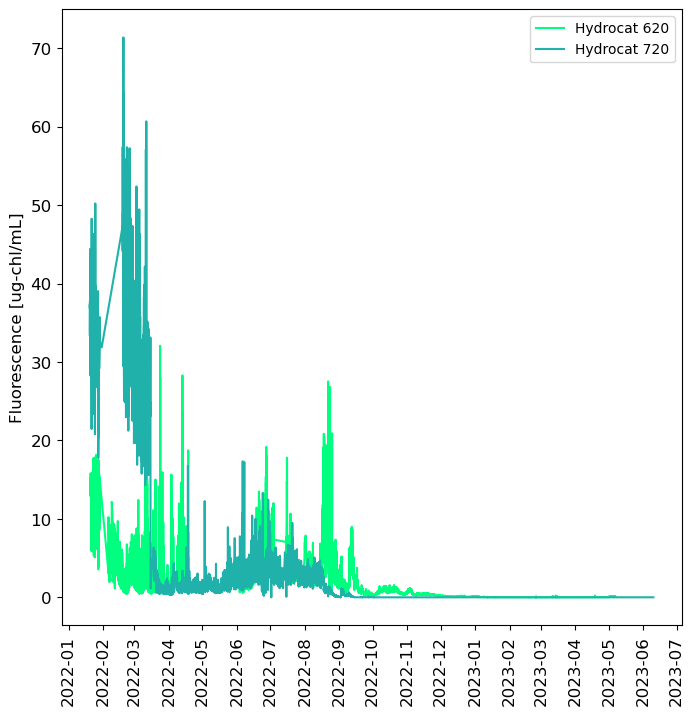

In [94]:
fig, ax = plt.subplots(figsize = [8,8])

ax.plot(hydrocat620["DateTime"], hydrocat620["hydrocatFluorescence"], color = '#00ff7f', label = 'Hydrocat 620')
ax.plot(hydrocat720["DateTime"], hydrocat720["hydrocatFluorescence"], color = '#20b2aa', label = 'Hydrocat 720')

ax.set_ylabel('Fluorescence [ug-chl/mL]', fontsize = 12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.legend()

# Monthly Time Series Chlorophyll Averages (with error bars)

Here, I am dropping the last row and column of `chl_avg` and `chl_std`, which provide the "Grand Totals."

In [165]:
mn = chl_avg.iloc[0:12,25]
std = chl_avg.iloc[0:12,25]
MN = pd.DataFrame(mn)
STD = pd.DataFrame(std)

STD.index

Index(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec'],
      dtype='object')

In [166]:
chl_avg = chl_avg.iloc[0:12, 0:25]
chl_std = chl_std.iloc[0:12, 0:25]

Text(0.5, 1.0, 'Monthly Averages')

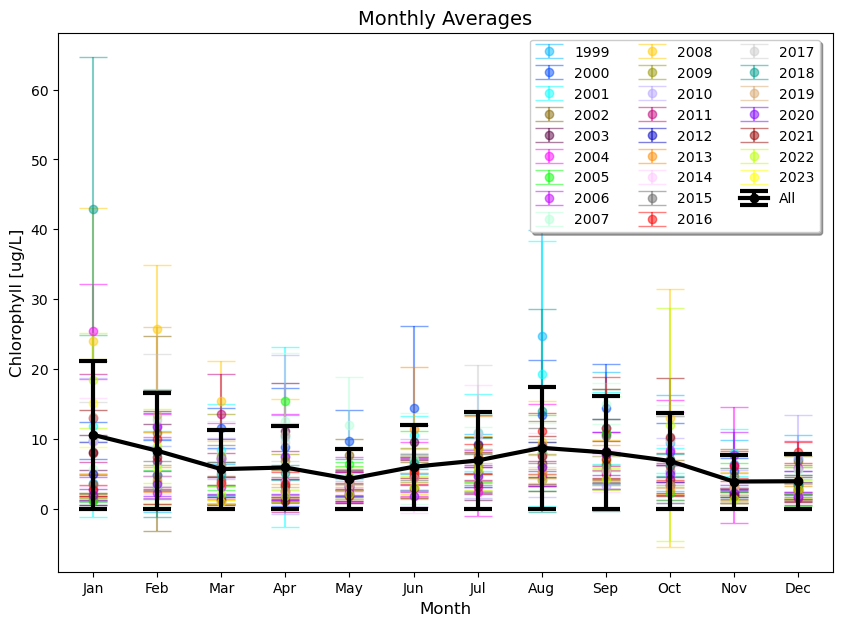

In [230]:
fig, ax = plt.subplots(figsize = [10,7])

# I literally just googled "lots of distinguishable colors" and got this
clrs = ['#00B7FF', '#004DFF', '#00FFFF', '#826400', '#580041', 
        '#FF00FF', '#00FF00', '#C500FF', '#B4FFD7', '#FFCA00',
        '#969600', '#B4A2FF', '#C20078', '#0000C1', '#FF8B00', '#FFC8FF', 
        '#666666', '#FF0000', '#CCCCCC', '#009E8F', '#D7A870', '#8200FF', 
        '#960000', '#BBFF00', '#FFFF00', '#006F00']

i = 0
for k in chl_avg.keys():
    ax.errorbar(chl_avg.index, chl_avg[k], yerr = chl_std[k], marker = 'o', color = clrs[i], linestyle = 'none', alpha = 0.5, capsize=10, label = k)
    i += 1

# the squeeze() function here is just forcing MN and STD to be series
# and making the dimensions of it all work
ax.errorbar(MN.index, MN.squeeze(), yerr = STD.squeeze(), marker = 'o', color = 'k', label = 'All', lw = 3, capsize = 10, capthick = 3, zorder = 3)
ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1),
          ncol=3, fancybox=True, shadow=True)
ax.set_ylabel('Chlorophyll [ug/L]', fontsize = 12)
ax.set_xlabel('Month', fontsize = 12)
ax.set_title('Monthly Averages', fontsize = 14)

# Compare Hydrocat fluorescence with time series chlorophyll
Hydrocat fluorescence does not look very convincing...

Text(0, 0.5, 'Chlorophyll [ug/L]')

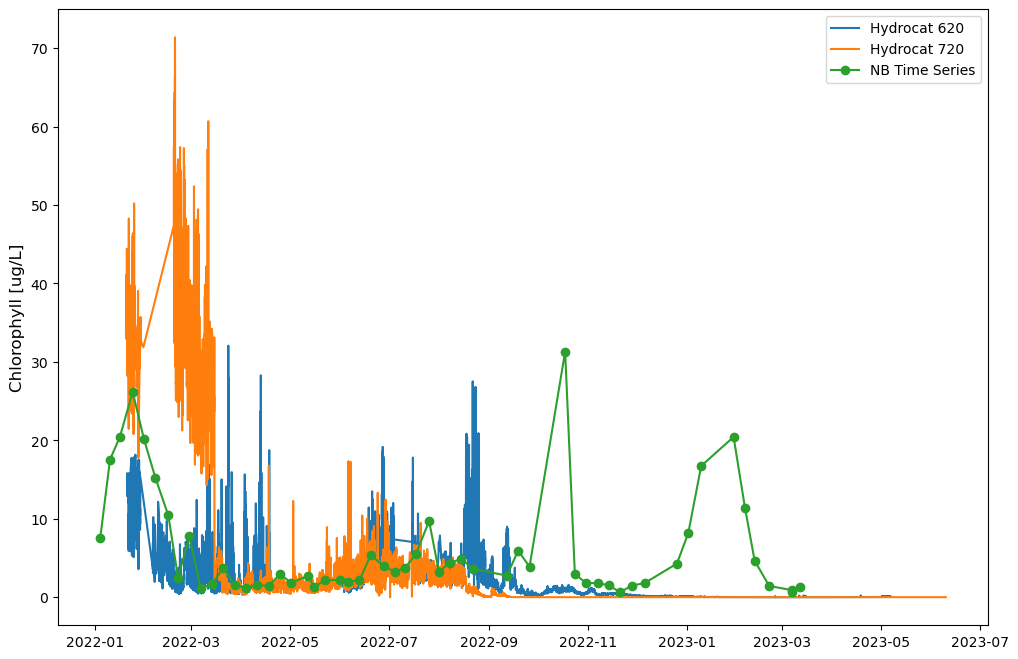

In [237]:
fig, ax = plt.subplots(figsize = [12,8])

ax.plot(hydrocat620['DateTime'], hydrocat620['hydrocatFluorescence'], label = 'Hydrocat 620')
ax.plot(hydrocat720['DateTime'], hydrocat720['hydrocatFluorescence'], label = 'Hydrocat 720')
ax.plot(chl_present['Sample Date'], chl_present['Surface Chla All (µg/L)'],
        marker = 'o', label = 'NB Time Series')
ax.legend()
ax.set_ylabel('Chlorophyll [ug/L]', fontsize = 12)